### Natural Language Processing Assignment

#### Course: TIPP Intake 1

#### Student Name: Koay Seng Tian (sengtian@yahoo.com)

Note: by typing your full name, it is taken that you have read and understood the declaration below.

#### Declaration:

- I declare that this report is my original work. I understand that if I am suspected of plagiarism, my enrolment in the programme may be terminated.

- I declare that I have a back-up electronic copy of this report for immediate submission.


In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyLDAvis
import pyLDAvis.sklearn
import re
import string

In [2]:
num_topics = 15
num_top_words = 15

# for reproducibility, 1337 is arbitrarily set
np.random.seed(1337)

# Load Dataset

In [3]:
# dataset file name and its full pathname
dataset_filename = 'News Set A.csv'
dataset_dir = 'datasets'
dataset_fullpathname = os.path.join(os.getcwd(), dataset_dir)
dataset_fullpathname = os.path.join(dataset_fullpathname, dataset_filename)

# load the "News Set A.csv" as a dataframe
# and drop the first unnamed index column
df = pd.read_csv(dataset_fullpathname, encoding='utf-8', error_bad_lines=False)
df.drop(df.columns[0], axis=1)

,id,title,publication,author,date,year,month,url,content
0,17283,House Republicans Fret About Winning Their Hea...,New York Times,Carl Hulse,2016-12-31,2016.0,12.0,NaN,WASHINGTON — Congressional Republicans have...
1,17284,Rift Between Officers and Residents as Killing...,New York Times,Benjamin Mueller and Al Baker,2017-06-19,2017.0,6.0,NaN,"After the bullet shells get counted, the blood..."
2,17285,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",New York Times,Margalit Fox,2017-01-06,2017.0,1.0,NaN,"When Walt Disney’s “Bambi” opened in 1942, cri..."
3,17286,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",New York Times,William McDonald,2017-04-10,2017.0,4.0,NaN,"Death may be the great equalizer, but it isn’t..."
4,17287,Kim Jong-un Says North Korea Is Preparing to T...,New York Times,Choe Sang-Hun,2017-01-02,2017.0,1.0,NaN,"SEOUL, South Korea — North Korea’s leader, ..."
...,...,...,...,...,...,...,...,...,...
49995,73465,"Rex Tillerson Says Climate Change Is Real, but …",Atlantic,Robinson Meyer,2017-01-11,2017.0,1.0,NaN,"As chairman and CEO of ExxonMobil, Rex Tillers..."
49996,73466,The Biggest Intelligence Questions Raised by t...,Atlantic,Amy Zegart,2017-01-11,2017.0,1.0,NaN,I’ve spent nearly 20 years looking at intellig...
49997,73467,Trump Announces Plan That Does Little to Resol...,Atlantic,Jeremy Venook,2017-01-11,2017.0,1.0,NaN,Donald Trump will not be taking necessary st...
49998,73468,Dozens of For-Profit Colleges Could Soon Close,Atlantic,Emily DeRuy,2017-01-11,2017.0,1.0,NaN,Dozens of colleges could be forced to close ...


# Clean the Data

In [4]:
def clean_text(text):
    # change to lower case
    text = text.lower()

    # remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    # remove punctuations\n",
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    # remove punctuation marks specifics to this dataset
    text = re.sub(r'[—’“”]', ' ', text)
    
    # remove words less than 3 characters
    text = re.sub(r'\b\w{1,3}\b', ' ', text)
    
    # remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [5]:
docs = pd.DataFrame(df.content.apply(lambda x: clean_text(x)))

In [6]:
docs = docs.content.values

In [7]:
type(docs)
docs.shape

numpy.ndarray

(50000,)

In [8]:
docs[4]

'seoul south korea north korea leader said sunday that country making final preparations conduct first test intercontinental ballistic missile bold statement less than month before inauguration donald trump although north korea conducted five nuclear tests last decade more than ballistic missile tests alone although habitually threatens attack united states with nuclear weapons country never intercontinental ballistic missile icbm annual year speech which broadcast north kctv sunday spoke proudly strides said country made nuclear weapons ballistic missile programs said north korea would continue bolster weapons programs long united states remained hostile continued joint military exercises with south korea have reached final stage preparations intercontinental ballistic rocket said analysts region have said might conduct another weapons test coming months taking advantage leadership changes united states south korea trump will sworn south korea president park whose powers were suspende

# Exploratory Data Analysis

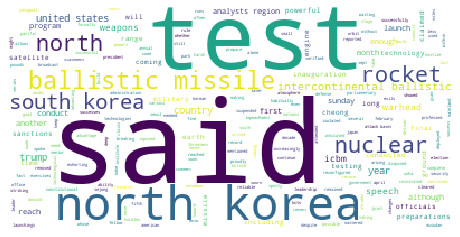

In [9]:
# generate word cloud
def showWordCloud(texts):
    words = ','.join(list(texts))
 
    # show it as wordCloud
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(words)
    
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(wordcloud.to_image())
    
# show a word cloud for news ID #17287
showWordCloud(docs[4].split())

In [10]:
# extracted from NLP lab exercise
# also same function can be found in scikit-learn website
def display_top_words(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()


# Latent Dirichlet Allocation Analysis

In [12]:
# LDA

# create Document-Word matrix
vectorizer = CountVectorizer(analyzer='word',
                             max_df=0.9,
                             min_df=5, 
                             stop_words='english',
                             lowercase=True)
data_vectorized = vectorizer.fit_transform(docs)


In [13]:
# build a LDA model

lda_model = LatentDirichletAllocation(
    n_components=num_topics,      # Number of topics
    max_iter=5,                   # Max learning iterations
    learning_method='online',   
    learning_offset=50.,
    n_jobs=-1                     # use all available CPUs
)


In [14]:
# this will take some time
lda_output = lda_model.fit_transform(data_vectorized)

# model attributes
print(lda_model)  

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=15, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)


In [15]:
# Number of documents, Number of topics
lda_output.shape

(50000, 15)

In [17]:
feature_names = vectorizer.get_feature_names()
display_top_words(lda_model, feature_names, num_top_words)

Topic 0:
students texas breitbart school immigration university border mexico immigrants illegal student state education college schools

Topic 1:
company like business apple facebook google million tesla said year time companies just technology says

Topic 2:
said people women family told just children like know time life says going years home

Topic 3:
trump said clinton president donald campaign republican obama people presidential hillary party election going says

Topic 4:
twitter film like media star black people just best year movie series video social wrote

Topic 5:
percent million said year money health government jobs years people billion care american plan economic

Topic 6:
said water health people study medical disease according research cases zika patients risk cancer drug

Topic 7:
said china north korea country european minister united europe world south government party chinese britain

Topic 8:
said isis military syria united state security government islamic iran st

In [18]:
# Find dominant topics for document

# Styling
def color_norm(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
    
def color_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominantTopic'] = dominant_topic

# Apply Style to first 25 document
df_document_topic2 = df_document_topic.head(25).style.applymap(color_norm).applymap(color_bold)
df_document_topic2


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominantTopic
Doc0,0.000000,0.000000,0.000000,0.250000,0.000000,0.420000,0.000000,0.000000,0.000000,0.060000,0.000000,0.010000,0.260000,0.000000,0.000000,5
Doc1,0.010000,0.010000,0.250000,0.010000,0.000000,0.070000,0.000000,0.000000,0.000000,0.010000,0.000000,0.080000,0.070000,0.220000,0.260000,14
Doc2,0.050000,0.120000,0.170000,0.010000,0.210000,0.000000,0.020000,0.110000,0.000000,0.000000,0.010000,0.240000,0.030000,0.030000,0.000000,11
Doc3,0.010000,0.010000,0.020000,0.030000,0.390000,0.000000,0.060000,0.030000,0.010000,0.000000,0.160000,0.200000,0.030000,0.020000,0.030000,4
Doc4,0.000000,0.040000,0.000000,0.060000,0.000000,0.000000,0.000000,0.680000,0.210000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,7
Doc5,0.000000,0.000000,0.200000,0.000000,0.260000,0.000000,0.000000,0.150000,0.220000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,4
Doc6,0.020000,0.000000,0.000000,0.120000,0.000000,0.000000,0.010000,0.740000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,7
Doc7,0.000000,0.040000,0.240000,0.010000,0.060000,0.030000,0.450000,0.000000,0.000000,0.000000,0.060000,0.080000,0.000000,0.020000,0.000000,6
Doc8,0.000000,0.020000,0.210000,0.010000,0.280000,0.000000,0.020000,0.000000,0.000000,0.010000,0.110000,0.250000,0.090000,0.000000,0.000000,4
Doc9,0.040000,0.000000,0.600000,0.000000,0.030000,0.040000,0.120000,0.000000,0.010000,0.000000,0.000000,0.150000,0.000000,0.000000,0.000000,2


In [20]:
# Use pyLDAvis to visualise topic models

pyLDAvis.enable_notebook()

panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer)
panel

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.055014  0.053714       1        1  17.251060
9     -0.060077 -0.002363       2        1   8.807393
2      0.117188 -0.051885       3        1   8.619234
11     0.223121  0.003679       4        1   8.064834
5     -0.015849  0.223095       5        1   7.320126
4      0.190422 -0.092226       6        1   6.688967
8     -0.149629  0.056994       7        1   6.624014
1      0.117676  0.105404       8        1   6.054852
12    -0.153224  0.032203       9        1   5.377106
7     -0.076077  0.118080      10        1   5.064316
14    -0.132719 -0.221242      11        1   4.966277
6     -0.073917  0.077615      12        1   3.996386
13    -0.069752 -0.226616      13        1   3.994980
0     -0.144164 -0.022197      14        1   3.956375
10     0.171985 -0.054254      15        1   3.214081, topic_info=          Term           Freq          Total Category  logprob  loglift
47692    trump  149742.000000  149742.000000  Default  30.0000  30.0000
34965   police   31990.000000   31990.000000  Default  29.0000  29.0000
8399   clinton   54055.000000   54055.000000  Default  28.0000  28.0000
40039     said  201005.000000  201005.000000  Default  27.0000  27.0000
10329    court   16916.000000   16916.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
34753  playing    1296.641105    3362.335268  Topic15  -5.9066   2.4848
34931   points    1331.354909    6036.808331  Topic15  -5.8802   1.9260
50478     week    1410.722396   20453.220484  Topic15  -5.8223   0.7636
32330     open    1334.122444    8610.617107  Topic15  -5.8781   1.5729
51486    years    1343.068283   35409.028859  Topic15  -5.8714   0.1656

[1231 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
28        11  0.997764       abbas
52        11  0.994003    abdeslam
82         2  0.998295      abedin
146        1  0.083264    abortion
146        3  0.014305    abortion
...      ...       ...         ...
51591     15  0.014412       young
51747     14  0.998471       zetas
51767     12  0.999456        zika
51833      8  0.993987  zuckerberg
51833     10  0.005134  zuckerberg

[4732 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 10, 3, 12, 6, 5, 9, 2, 13, 8, 15, 7, 14, 1, 11])

In [ ]:
# Find Good Model Performance
# using (Perplexity and log-likelihood)

kmin = 10
kmax = 15

topic_models = []

# try each value of k
for k in range(kmin, kmax+1):
    print("Applying LDA for k=%d ..." % k )
    model = LatentDirichletAllocation(
         n_components=k,      # Number of topics
         max_iter=5,                   # Max learning iterations
         learning_method='online',   
         learning_offset=50.,
         n_jobs=-1)

    output = model.fit_transform(tf) 
    log_likelihood = lda_model.score(tf)
    perplexity = model.perplexity(tf)
    topic_models.append((k, model, output, log_likelihood, perplexity))

for model in topic_models:
    print('topics : % 2d, Log Likelihood : % 5.2f   Perplexity : %5.2f' %(model[0], model[3], model[4]))

# Non-Negative Matrix Factorization (NMF)

In [ ]:
# just to ensure that the docs haven't been changed
print(docs[4])

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,
                                   min_df=2,
                                   stop_words='english',
                                   max_features=1000)

tfidf = tfidf_vectorizer.fit_transform(docs)

In [21]:
nmf_model = NMF(n_components=num_topics, 
                alpha=.1,
                l1_ratio=.5)


In [22]:
# this will take some time
nmf_output = nmf_model.fit_transform(data_vectorized)

# model attributes
print(nmf_model)  


NMF(alpha=0.1, beta_loss='frobenius', init=None, l1_ratio=0.5, max_iter=200,
    n_components=15, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)


In [23]:
nmf_output.shape

(50000, 15)

In [25]:
print("\nTopics in NMF mode:")
feature_names = vectorizer.get_feature_names()
display_top_words(nmf_model, feature_names, num_top_words)



Topics in NMF mode:
Topic 0:
trump donald campaign president republican election pence march going presidential business nominee romney debate washington

Topic 1:
said told people asked added statement friday family interview wednesday monday thursday officials tuesday called

Topic 2:
says sanders people asks cruz clinton trump like america march kasich obama country doesn asked

Topic 3:
clinton hillary campaign sanders state voters email democratic emails foundation presidential debate secretary election department

Topic 4:
people think going know just like want really question right things good country thing make

Topic 5:
state court federal department states case judge justice government texas public order school supreme rights

Topic 6:
police officers officer update black dallas july shot shooting city reports people killed suspect department

Topic 7:
rubio cruz february campaign voters carolina kasich republican south vote poll party bush hillary marco

Topic 8:
obama pres

In [26]:
# column names
topicnames = ["Topic" + str(i) for i in range(nmf_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(docs))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominantTopic'] = dominant_topic

# Apply Style to first 25 document
df_document_topic2 = df_document_topic.head(25).style.applymap(color_norm).applymap(color_bold)
df_document_topic2

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominantTopic
Doc0,0.150000,0.100000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,0.430000,0.000000,0.070000,0.000000,0.000000,0.000000,0.130000,8
Doc1,0.000000,1.240000,0.000000,0.000000,0.330000,0.120000,1.480000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.380000,6
Doc2,0.000000,0.270000,0.000000,0.000000,0.060000,0.040000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.190000,0.520000,0.020000,13
Doc3,0.000000,0.050000,0.000000,0.020000,0.130000,0.020000,0.030000,0.000000,0.010000,0.030000,0.000000,0.030000,0.050000,0.450000,0.000000,13
Doc4,0.080000,0.320000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.570000,0.000000,0.000000,12
Doc5,0.000000,0.060000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.030000,0.010000,1
Doc6,0.090000,0.140000,0.000000,0.000000,0.030000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.020000,0.270000,0.000000,0.000000,12
Doc7,0.000000,0.680000,0.070000,0.000000,0.480000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.430000,0.180000,1
Doc8,0.000000,0.350000,0.000000,0.020000,0.030000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.020000,0.000000,0.360000,0.000000,13
Doc9,0.000000,0.190000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.280000,0.000000,13


In [97]:
def LDAvsNMF_Topics(model_lda, model_nmf, vector, num_top_word):
    lda_nmf_df = pd.DataFrame(columns=['Topic', 'LDA', 'NMF'])
    
    ldaTopicList = []
    nmfTopicList = []
    
    for _, topic in enumerate(model_lda.components_):
        ldaTopicList.append(" ".join([vector.get_feature_names()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))

    for _, topic in enumerate(model_nmf.components_):
        nmfTopicList.append(" ".join([vector.get_feature_names()[i] for i in topic.argsort()[:-num_top_words - 1:-1]]))
    
    zipped = zip (ldaTopicList, nmfTopicList)

    for idx, (lda, nmf) in enumerate(zipped):
        lda_nmf_df.loc[idx] = [idx] + [lda] + [nmf]
        
    return lda_nmf_df
        

In [98]:
lda_nmf_df = LDAvsNMF_Topics(lda_model, nmf_model, vectorizer, num_top_words)

In [99]:
lda_nmf_df

,Topic,LDA,NMF
0,0,students texas breitbart school immigration un...,trump donald campaign president republican ele...
1,1,company like business apple facebook google mi...,said told people asked added statement friday ...
2,2,said people women family told just children li...,says sanders people asks cruz clinton trump li...
3,3,trump said clinton president donald campaign r...,clinton hillary campaign sanders state voters ...
4,4,twitter film like media star black people just...,people think going know just like want really ...
5,5,percent million said year money health governm...,state court federal department states case jud...
6,6,said water health people study medical disease...,police officers officer update black dallas ju...
7,7,said china north korea country european minist...,rubio cruz february campaign voters carolina k...
8,8,said isis military syria united state security...,obama president house white administration rep...
9,9,trump said clinton president news house white ...,isis attack killed people believed syria group...


In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

In [ ]:
# Insert your assignment codes 

#### Please answer the two questions in the next cell:

Question 1: Was the outcome of the topic modelling satisfactory. Why or why not ?
Question 2: Which approach (LDA or NFM) works better? Why?